# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "CF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'CF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups      
Sample_148  Q9P0K9                 16.221
Sample_163  B7Z4G8;F5GZ08;P51693   21.301
Sample_027  P11597;P11597-2        19.602
Sample_197  P14151;P14151-2        17.420
Sample_042  P43234                 15.937
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by CF: runs/alzheimer_study/preds/pred_real_na_CF.csv


Sample ID   protein groups                                        
Sample_180  D3YTI2;F2Z2Q9;G5E9R5;P24666;P24666-2;P24666-3;P24666-4   16.826
Sample_185  P31151                                                   11.721
Sample_119  A0A087WTT8;A0A0A0MQX5;O94779;O94779-2                    11.089
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 11.930
            A0A075B6Q5                 13.162
            A0A075B6R2                 12.224
            A0A075B6S5                 14.410
            A0A087WSY4                 13.723
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.019
            Q9UI40;Q9UI40-2            13.845
            Q9UIW2                     13.094
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.355
            Q9UP79                     13.499
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.226,15.050,16.842,19.863,16.403,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.602,19.067,...,15.528,15.576,14.055,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.880,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.790,17.705,17.039,15.440,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.639,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,15.050,15.345,17.084,18.708,14.249,19.433,11.978,11.303
Sample_207,15.739,16.877,15.469,16.898,14.070,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,11.930,...,16.012,15.178,13.030,15.050,16.842,19.863,13.546,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,13.878,19.067,16.188,...,15.528,15.576,12.400,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,13.654,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,12.420,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,11.719,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,13.476,15.345,17.084,18.708,14.249,19.433,12.888,12.005
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 407.17it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.01it/s]

100%|██████████| 2/2 [00:00<00:00,  5.00it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.01it/s]

100%|██████████| 3/3 [00:00<00:00,  2.92it/s]

100%|██████████| 3/3 [00:00<00:00,  3.08it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.11it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.80it/s]

100%|██████████| 4/4 [00:01<00:00,  3.41it/s]

100%|██████████| 4/4 [00:01<00:00,  3.65it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.77it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.74it/s]

 80%|████████  | 4/5 [00:01<00:00,  3.35it/s]

100%|██████████| 5/5 [00:01<00:00,  3.15it/s]

100%|██████████| 5/5 [00:01<00:00,  3.39it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  6.37it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.39it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.43it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.84it/s]

100%|██████████| 6/6 [00:02<00:00,  2.50it/s]

100%|██████████| 6/6 [00:02<00:00,  2.97it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.00it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.53it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  3.78it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.91it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  2.47it/s]

100%|██████████| 7/7 [00:02<00:00,  2.37it/s]

100%|██████████| 7/7 [00:02<00:00,  2.86it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  3.91it/s]

 38%|███▊      | 3/8 [00:01<00:01,  2.78it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.41it/s]

 62%|██████▎   | 5/8 [00:02<00:01,  2.25it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.32it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.49it/s]

100%|██████████| 8/8 [00:03<00:00,  2.57it/s]

100%|██████████| 8/8 [00:03<00:00,  2.55it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:02,  3.31it/s]

 33%|███▎      | 3/9 [00:01<00:02,  2.49it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.39it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.52it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.52it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.59it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.58it/s]

100%|██████████| 9/9 [00:03<00:00,  2.73it/s]

100%|██████████| 9/9 [00:03<00:00,  2.63it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.50it/s]

 30%|███       | 3/10 [00:00<00:02,  3.04it/s]

 40%|████      | 4/10 [00:01<00:02,  2.76it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.51it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.47it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.57it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.54it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.63it/s]

100%|██████████| 10/10 [00:03<00:00,  2.65it/s]

100%|██████████| 10/10 [00:03<00:00,  2.70it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  4.81it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.49it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.75it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.53it/s]

 55%|█████▍    | 6/11 [00:02<00:01,  2.52it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.58it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.64it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.56it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.55it/s]

100%|██████████| 11/11 [00:04<00:00,  2.55it/s]

100%|██████████| 11/11 [00:04<00:00,  2.68it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.69it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.46it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.03it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.83it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.70it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.56it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.72it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.72it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.79it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.86it/s]

100%|██████████| 12/12 [00:04<00:00,  2.82it/s]

100%|██████████| 12/12 [00:04<00:00,  2.87it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.05it/s]

 23%|██▎       | 3/13 [00:00<00:03,  2.88it/s]

 31%|███       | 4/13 [00:01<00:03,  2.35it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.36it/s]

 46%|████▌     | 6/13 [00:02<00:03,  2.29it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.42it/s]

 62%|██████▏   | 8/13 [00:03<00:01,  2.66it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.73it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.77it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.91it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.95it/s]

100%|██████████| 13/13 [00:04<00:00,  3.03it/s]

100%|██████████| 13/13 [00:04<00:00,  2.77it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.43it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.95it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.34it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.04it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.52it/s]

 50%|█████     | 7/14 [00:02<00:03,  2.32it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.24it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.18it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.39it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.52it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.59it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.73it/s]

100%|██████████| 14/14 [00:05<00:00,  2.86it/s]

100%|██████████| 14/14 [00:05<00:00,  2.72it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  6.20it/s]

 20%|██        | 3/15 [00:00<00:03,  3.61it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.29it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.33it/s]

 40%|████      | 6/15 [00:01<00:02,  3.20it/s]

 47%|████▋     | 7/15 [00:02<00:02,  3.09it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.08it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.09it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  3.17it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.21it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.27it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.34it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.71it/s]

100%|██████████| 15/15 [00:04<00:00,  2.49it/s]

100%|██████████| 15/15 [00:04<00:00,  3.04it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.006      0.082 0.029          0.699 0.394       0.102   
2             0.005 0.004      0.056 0.019          0.763 0.093       0.688   
3             0.005 0.004      0.062 0.026          0.764 0.096       0.685   
4             0.004 0.002      0.053 0.017          0.762 0.099       0.699   
5             0.005 0.004      0.069 0.024          0.747 0.095       0.708   
6             0.007 0.006      0.077 0.035          0.768 0.092       0.741   
7             0.006 0.005      0.076 0.032          0.800 0.082       0.787   
8             0.005 0.004      0.062 0.020          0.811 0.086       0.791   
9             0.005 0.003      0.055 0.016          0.800 0.077       0.782   
10            0.005 0.005      0.054 0.022          0.799 0.084       0.786   
11            0.005 0.003      0.057 0.019          0.801 0.082       0.793   
12            0.007 0.005      0.065 0.022          0.795 0.084       0.789   
13            0.007 0.005      0.080 0.038          0.793 0.082       0.791   
14            0.006 0.004      0.076 0.027          0.791 0.080       0.781   
15            0.006 0.005      0.081 0.032          0.792 0.083       0.778   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.085   0.171 0.131                  0.544 0.041        0.844   
2          0.094   0.716 0.061                  0.761 0.047        0.846   
3          0.095   0.716 0.064                  0.761 0.050        0.840   
4          0.089   0.723 0.067                  0.766 0.055        0.844   
5          0.100   0.720 0.063                  0.762 0.050        0.850   
6          0.099   0.749 0.071                  0.786 0.059        0.887   
7          0.093   0.790 0.070                  0.820 0.058        0.903   
8          0.096   0.797 0.073                  0.826 0.061        0.903   
9          0.093   0.788 0.070                  0.819 0.059        0.905   
10         0.097   0.789 0.073                  0.820 0.063        0.905   
11         0.093   0.793 0.069                  0.823 0.059        0.902   
12         0.097   0.789 0.073                  0.819 0.064        0.900   
13         0.095   0.788 0.072                  0.819 0.063        0.899   
14         0.095   0.783 0.071                  0.814 0.062        0.898   
15         0.095   0.782 0.072                  0.813 0.062        0.897   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.067                  0.819 0.089        210.000 0.000  
2          0.056                  0.826 0.065        210.000 0.000  
3          0.054                  0.819 0.064        210.000 0.000  
4          0.057                  0.826 0.063        210.000 0.000  
5          0.058                  0.833 0.065        210.000 0.000  
6          0.049                  0.874 0.052        210.000 0.000  
7          0.048                  0.892 0.050        210.000 0.000  
8          0.050                  0.893 0.052        210.000 0.000  
9          0.049                  0.898 0.047        210.000 0.000  
10         0.048                  0.899 0.046        210.000 0.000  
11         0.050                  0.896 0.048        210.000 0.000  
12         0.052                  0.893 0.050        210.000 0.000  
13         0.052                  0.892 0.050        210.000 0.000  
14         0.053                  0.892 0.051        210.000 0.000  
15         0.053                  0.890 0.051 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 465.21it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.36it/s]

100%|██████████| 2/2 [00:00<00:00,  3.35it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.31it/s]

100%|██████████| 3/3 [00:00<00:00,  3.46it/s]

100%|██████████| 3/3 [00:00<00:00,  3.71it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.78it/s]

 75%|███████▌  | 3/4 [00:01<00:00,  2.80it/s]

100%|██████████| 4/4 [00:01<00:00,  2.47it/s]

100%|██████████| 4/4 [00:01<00:00,  2.66it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  3.77it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.05it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.72it/s]

100%|██████████| 5/5 [00:01<00:00,  2.69it/s]

100%|██████████| 5/5 [00:01<00:00,  2.84it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.37it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.57it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.72it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.28it/s]

100%|██████████| 6/6 [00:02<00:00,  2.07it/s]

100%|██████████| 6/6 [00:02<00:00,  2.45it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.63it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.89it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.97it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.93it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  2.91it/s]

100%|██████████| 7/7 [00:02<00:00,  2.61it/s]

100%|██████████| 7/7 [00:02<00:00,  2.97it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.23it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.97it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.52it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.26it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  2.81it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.72it/s]

100%|██████████| 8/8 [00:02<00:00,  2.70it/s]

100%|██████████| 8/8 [00:02<00:00,  3.04it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.76it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.29it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.61it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.43it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.37it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.50it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.55it/s]

100%|██████████| 9/9 [00:03<00:00,  2.67it/s]

100%|██████████| 9/9 [00:03<00:00,  2.69it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.26it/s]

 30%|███       | 3/10 [00:00<00:01,  3.73it/s]

 40%|████      | 4/10 [00:01<00:01,  3.75it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.17it/s]

 60%|██████    | 6/10 [00:01<00:01,  2.74it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.57it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.50it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.53it/s]

100%|██████████| 10/10 [00:03<00:00,  2.53it/s]

100%|██████████| 10/10 [00:03<00:00,  2.83it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  4.18it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.06it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.02it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.85it/s]

 55%|█████▍    | 6/11 [00:02<00:01,  2.78it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.69it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.62it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.38it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.41it/s]

100%|██████████| 11/11 [00:04<00:00,  2.53it/s]

100%|██████████| 11/11 [00:04<00:00,  2.69it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.68it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.07it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.38it/s]

 42%|████▏     | 5/12 [00:01<00:03,  2.24it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.28it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.19it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.20it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.07it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.18it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.31it/s]

100%|██████████| 12/12 [00:05<00:00,  2.32it/s]

100%|██████████| 12/12 [00:05<00:00,  2.36it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  5.81it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.99it/s]

 31%|███       | 4/13 [00:01<00:02,  3.58it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.09it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.92it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.63it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.80it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.83it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.90it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.73it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.37it/s]

100%|██████████| 13/13 [00:04<00:00,  2.32it/s]

100%|██████████| 13/13 [00:04<00:00,  2.78it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.80it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.49it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.85it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.79it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.59it/s]

 50%|█████     | 7/14 [00:02<00:02,  2.46it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.47it/s]

 64%|██████▍   | 9/14 [00:03<00:01,  2.62it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.67it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.73it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.31it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.12it/s]

100%|██████████| 14/14 [00:05<00:00,  1.96it/s]

100%|██████████| 14/14 [00:05<00:00,  2.45it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  6.02it/s]

 20%|██        | 3/15 [00:00<00:02,  4.18it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.43it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.36it/s]

 40%|████      | 6/15 [00:01<00:02,  3.27it/s]

 47%|████▋     | 7/15 [00:02<00:02,  3.16it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  3.08it/s]

 60%|██████    | 9/15 [00:02<00:02,  3.00it/s]

 67%|██████▋   | 10/15 [00:03<00:01,  2.75it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  2.82it/s]

 80%|████████  | 12/15 [00:03<00:01,  2.77it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.66it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.71it/s]

100%|██████████| 15/15 [00:04<00:00,  2.74it/s]

100%|██████████| 15/15 [00:04<00:00,  3.01it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.067 0.029          0.107 0.279       0.011   
2             0.007 0.006      0.080 0.030          0.745 0.100       0.676   
3             0.004 0.002      0.052 0.014          0.733 0.090       0.677   
4             0.005 0.005      0.060 0.023          0.816 0.096       0.748   
5             0.005 0.004      0.054 0.020          0.797 0.097       0.750   
6             0.005 0.003      0.059 0.020          0.799 0.097       0.748   
7             0.005 0.004      0.064 0.024          0.797 0.100       0.734   
8             0.006 0.005      0.065 0.023          0.794 0.099       0.768   
9             0.004 0.002      0.057 0.020          0.795 0.100       0.774   
10            0.004 0.002      0.049 0.013          0.794 0.096       0.774   
11            0.004 0.002      0.052 0.014          0.787 0.097       0.758   
12            0.005 0.004      0.054 0.015          0.792 0.095       0.763   
13            0.005 0.003      0.057 0.021          0.823 0.090       0.791   
14            0.005 0.003      0.052 0.014          0.835 0.092       0.798   
15            0.004 0.002      0.039 0.008          0.831 0.091       0.817   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.028   0.019 0.050                  0.501 0.013        0.861   
2          0.112   0.703 0.085                  0.751 0.067        0.832   
3          0.106   0.698 0.079                  0.747 0.063        0.828   
4          0.110   0.774 0.080                  0.810 0.062        0.883   
5          0.115   0.765 0.077                  0.802 0.060        0.886   
6          0.111   0.766 0.077                  0.803 0.061        0.883   
7          0.107   0.757 0.077                  0.796 0.061        0.881   
8          0.111   0.775 0.081                  0.809 0.066        0.900   
9          0.113   0.778 0.083                  0.812 0.067        0.899   
10         0.114   0.778 0.081                  0.811 0.067        0.897   
11         0.116   0.765 0.079                  0.801 0.065        0.905   
12         0.117   0.771 0.079                  0.806 0.065        0.906   
13         0.106   0.803 0.079                  0.832 0.066        0.916   
14         0.101   0.812 0.076                  0.840 0.063        0.918   
15         0.090   0.821 0.074                  0.847 0.062        0.915   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.829 0.088        210.000 0.000  
2          0.058                  0.793 0.079        210.000 0.000  
3          0.057                  0.787 0.079        210.000 0.000  
4          0.053                  0.849 0.077        210.000 0.000  
5          0.050                  0.854 0.071        210.000 0.000  
6          0.051                  0.850 0.073        210.000 0.000  
7          0.051                  0.848 0.072        210.000 0.000  
8          0.051                  0.875 0.065        210.000 0.000  
9          0.051                  0.873 0.065        210.000 0.000  
10         0.051                  0.870 0.066        210.000 0.000  
11         0.047                  0.885 0.054        210.000 0.000  
12         0.047                  0.886 0.057        210.000 0.000  
13         0.045                  0.896 0.054        210.000 0.000  
14         0.045                  0.899 0.053        210.000 0.000  
15         0.046                  0.896 0.053 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1039.22it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 24.72it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 26.39it/s]

100%|██████████| 3/3 [00:00<00:00, 26.13it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 20.43it/s]

100%|██████████| 4/4 [00:00<00:00, 18.23it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 80%|████████  | 4/5 [00:00<00:00, 28.38it/s]

100%|██████████| 5/5 [00:00<00:00, 26.46it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 67%|██████▋   | 4/6 [00:00<00:00, 30.21it/s]

100%|██████████| 6/6 [00:00<00:00, 26.47it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 57%|█████▋    | 4/7 [00:00<00:00, 27.46it/s]

100%|██████████| 7/7 [00:00<00:00, 25.70it/s]

100%|██████████| 7/7 [00:00<00:00, 25.92it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 50%|█████     | 4/8 [00:00<00:00, 28.55it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 24.35it/s]

100%|██████████| 8/8 [00:00<00:00, 24.39it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 44%|████▍     | 4/9 [00:00<00:00, 29.69it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 25.30it/s]

100%|██████████| 9/9 [00:00<00:00, 25.74it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 26.88it/s]

 60%|██████    | 6/10 [00:00<00:00, 23.58it/s]

 90%|█████████ | 9/10 [00:00<00:00, 23.94it/s]

100%|██████████| 10/10 [00:00<00:00, 23.78it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 19.28it/s]

 36%|███▋      | 4/11 [00:00<00:00, 11.40it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 11.40it/s]

 73%|███████▎  | 8/11 [00:00<00:00, 11.11it/s]

 91%|█████████ | 10/11 [00:00<00:00, 12.44it/s]

100%|██████████| 11/11 [00:00<00:00, 12.55it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 23.25it/s]

 50%|█████     | 6/12 [00:00<00:00, 20.00it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 18.91it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 17.27it/s]

100%|██████████| 12/12 [00:00<00:00, 18.36it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 22.33it/s]

 46%|████▌     | 6/13 [00:00<00:00, 19.86it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 17.43it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 16.35it/s]

100%|██████████| 13/13 [00:00<00:00, 17.97it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 29%|██▊       | 4/14 [00:00<00:00, 29.42it/s]

 50%|█████     | 7/14 [00:00<00:00, 25.77it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 24.40it/s]

 93%|█████████▎| 13/14 [00:00<00:00, 23.51it/s]

100%|██████████| 14/14 [00:00<00:00, 23.98it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 27.91it/s]

 40%|████      | 6/15 [00:00<00:00, 28.30it/s]

 60%|██████    | 9/15 [00:00<00:00, 28.03it/s]

 80%|████████  | 12/15 [00:00<00:00, 28.41it/s]

100%|██████████| 15/15 [00:00<00:00, 28.36it/s]

100%|██████████| 15/15 [00:00<00:00, 28.26it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.045 0.006          0.000 0.000       0.000   
2             0.003 0.001      0.042 0.006          0.719 0.092       0.602   
3             0.002 0.000      0.030 0.005          0.688 0.100       0.597   
4             0.003 0.002      0.034 0.009          0.689 0.104       0.590   
5             0.002 0.001      0.032 0.012          0.693 0.109       0.590   
6             0.002 0.001      0.031 0.006          0.689 0.095       0.583   
7             0.003 0.001      0.032 0.006          0.736 0.093       0.630   
8             0.002 0.001      0.031 0.006          0.723 0.084       0.634   
9             0.002 0.001      0.031 0.005          0.723 0.083       0.635   
10            0.002 0.001      0.031 0.011          0.731 0.086       0.651   
11            0.003 0.001      0.036 0.009          0.725 0.090       0.639   
12            0.004 0.003      0.043 0.016          0.715 0.098       0.636   
13            0.003 0.001      0.031 0.007          0.715 0.085       0.638   
14            0.002 0.000      0.028 0.002          0.709 0.086       0.628   
15            0.002 0.000      0.027 0.000          0.697 0.094       0.622   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.707   
2          0.112   0.649 0.083                  0.713 0.062        0.773   
3          0.116   0.633 0.090                  0.698 0.069        0.776   
4          0.108   0.631 0.092                  0.696 0.071        0.770   
5          0.115   0.632 0.099                  0.699 0.073        0.763   
6          0.110   0.627 0.092                  0.695 0.067        0.763   
7          0.129   0.672 0.098                  0.732 0.071        0.823   
8          0.109   0.671 0.084                  0.728 0.061        0.826   
9          0.120   0.671 0.089                  0.729 0.066        0.823   
10         0.120   0.684 0.092                  0.738 0.069        0.822   
11         0.120   0.674 0.093                  0.731 0.069        0.821   
12         0.123   0.668 0.098                  0.725 0.073        0.821   
13         0.119   0.667 0.086                  0.724 0.063        0.822   
14         0.119   0.659 0.086                  0.718 0.061        0.820   
15         0.121   0.650 0.093                  0.710 0.070        0.819   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.072                  0.650 0.078        210.000 0.000  
2          0.065                  0.708 0.084        210.000 0.000  
3          0.065                  0.709 0.078        210.000 0.000  
4          0.060                  0.702 0.073        210.000 0.000  
5          0.062                  0.693 0.075        210.000 0.000  
6          0.061                  0.695 0.075        210.000 0.000  
7          0.060                  0.766 0.074        210.000 0.000  
8          0.060                  0.773 0.074        210.000 0.000  
9          0.059                  0.766 0.076        210.000 0.000  
10         0.060                  0.767 0.077        210.000 0.000  
11         0.058                  0.765 0.079        210.000 0.000  
12         0.061                  0.762 0.080        210.000 0.000  
13         0.067                  0.765 0.084        210.000 0.000  
14         0.067                  0.761 0.083        210.000 0.000  
15         0.067                  0.765 0.083 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,13,2,12
score_time,1,2,1
test_precision,8,14,7
test_recall,11,15,10
test_f1,8,15,10
test_balanced_accuracy,8,15,10
test_roc_auc,10,14,8
test_average_precision,10,14,8
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  8.59it/s]

 21%|██▏       | 3/14 [00:00<00:01,  6.32it/s]

 29%|██▊       | 4/14 [00:00<00:01,  5.54it/s]

 36%|███▌      | 5/14 [00:00<00:01,  5.05it/s]

 43%|████▎     | 6/14 [00:01<00:01,  4.89it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.85it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  4.78it/s]

 64%|██████▍   | 9/14 [00:01<00:01,  4.80it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  4.81it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  4.82it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  4.84it/s]

 93%|█████████▎| 13/14 [00:02<00:00,  4.83it/s]

100%|██████████| 14/14 [00:02<00:00,  4.92it/s]

100%|██████████| 14/14 [00:02<00:00,  5.05it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 50%|█████     | 4/8 [00:00<00:00, 38.10it/s]

100%|██████████| 8/8 [00:00<00:00, 31.29it/s]

100%|██████████| 8/8 [00:00<00:00, 32.07it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00, 12.89it/s]

 40%|████      | 4/10 [00:00<00:00,  8.26it/s]

 50%|█████     | 5/10 [00:00<00:00,  7.62it/s]

 60%|██████    | 6/10 [00:00<00:00,  7.34it/s]

 70%|███████   | 7/10 [00:00<00:00,  7.19it/s]

 80%|████████  | 8/10 [00:01<00:00,  7.03it/s]

 90%|█████████ | 9/10 [00:01<00:00,  6.95it/s]

100%|██████████| 10/10 [00:01<00:00,  6.96it/s]

100%|██████████| 10/10 [00:01<00:00,  7.41it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf


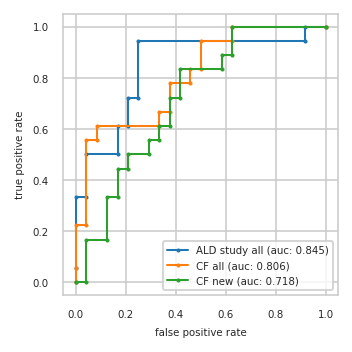

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       CF all       CF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.042 0.000
2          0.000 0.333  0.000 0.222  0.042 0.167
3          0.042 0.333  0.042 0.222  0.125 0.167
4          0.042 0.500  0.042 0.556  0.125 0.333
5          0.167 0.500  0.083 0.556  0.167 0.333
6          0.167 0.611  0.083 0.611  0.167 0.444
7          0.208 0.611  0.333 0.611  0.208 0.444
8          0.208 0.722  0.333 0.667  0.208 0.500
9          0.250 0.722  0.375 0.667  0.292 0.500
10         0.250 0.944  0.375 0.778  0.292 0.556
11         0.917 0.944  0.458 0.778  0.333 0.556
12         0.917 1.000  0.458 0.833  0.333 0.611
13         1.000 1.000  0.500 0.833  0.375 0.611
14           NaN   NaN  0.500 0.944  0.375 0.722
15           NaN   NaN  0.625 0.944  0.417 0.722
16           NaN   NaN  0.625 1.000  0.417 0.833
17           NaN   NaN  1.000 1.000  0.583 0.833
18           NaN   NaN    NaN   NaN  0.583 0.889
19           NaN   NaN    NaN   NaN  0.625 0.889
20           NaN   NaN    NaN   NaN  0.625 1.000
21           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,CF all,CF new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,P00740;P00740-2,Q9NX62,P51688
2,Q15782;Q15782-6,P08253,A0A087WXB8;Q9Y274
3,Q9NR34,P14174,Q9H741
4,P04075,Q9Y2T3;Q9Y2T3-3,P10644;P10644-2
5,P61981,P04075,A6PVN5;F6WIT2;Q15257;Q15257-2;Q15257-3
6,C9JF17;P05090,P61981,Q96GD0
7,P14174,P15151-2,A0A0J9YW36;Q9NZ72;Q9NZ72-2
8,Q9Y2T3;Q9Y2T3-3,P63104,None


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf


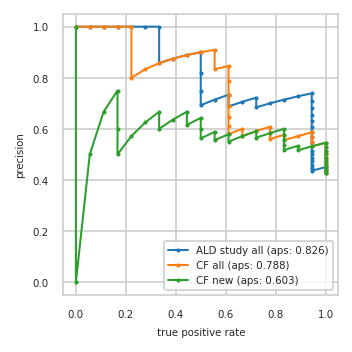

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          CF all          CF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.436 0.944     0.462 1.000     0.462 1.000
4          0.447 0.944     0.474 1.000     0.474 1.000
5          0.459 0.944     0.486 1.000     0.486 1.000
6          0.472 0.944     0.500 1.000     0.500 1.000
7          0.486 0.944     0.514 1.000     0.514 1.000
8          0.500 0.944     0.529 1.000     0.529 1.000
9          0.515 0.944     0.545 1.000     0.545 1.000
10         0.531 0.944     0.531 0.944     0.531 0.944
11         0.548 0.944     0.548 0.944     0.516 0.889
12         0.567 0.944     0.567 0.944     0.533 0.889
13         0.586 0.944     0.586 0.944     0.517 0.833
14         0.607 0.944     0.571 0.889     0.536 0.833
15         0.630 0.944     0.556 0.833     0.556 0.833
16         0.654 0.944     0.577 0.833     0.577 0.833
17         0.680 0.944     0.560 0.778     0.600 0.833
18         0.708 0.944     0.583 0.778     0.583 0.778
19         0.739 0.944     0.609 0.778     0.565 0.722
20         0.727 0.889     0.591 0.722     0.591 0.722
21         0.714 0.833     0.571 0.667     0.571 0.667
22         0.700 0.778     0.600 0.667     0.550 0.611
23         0.684 0.722     0.579 0.611     0.579 0.611
24         0.722 0.722     0.611 0.611     0.556 0.556
25         0.706 0.667     0.647 0.611     0.588 0.556
26         0.688 0.611     0.688 0.611     0.562 0.500
27         0.733 0.611     0.733 0.611     0.600 0.500
28         0.714 0.556     0.786 0.611     0.643 0.500
29         0.692 0.500     0.846 0.611     0.615 0.444
30         0.750 0.500     0.833 0.556     0.667 0.444
31         0.818 0.500     0.909 0.556     0.636 0.389
32         0.900 0.500     0.900 0.500     0.600 0.333
33         0.889 0.444     0.889 0.444     0.667 0.333
34         0.875 0.389     0.875 0.389     0.625 0.278
35         0.857 0.333     0.857 0.333     0.571 0.222
36         1.000 0.333     0.833 0.278     0.500 0.167
37         1.000 0.278     0.800 0.222     0.600 0.167
38         1.000 0.222     1.000 0.222     0.750 0.167
39         1.000 0.167     1.000 0.167     0.667 0.111
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf


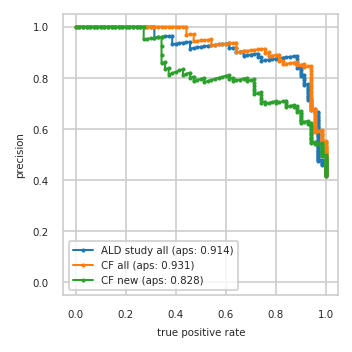

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf


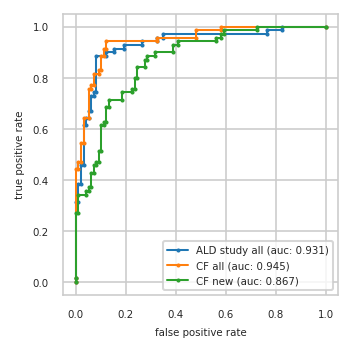

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_CF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF all.pkl'),
 'results_CF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf')}